In [1]:
import scanpy as sc
import os
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as ad

import muon as mu
from muon import atac as ac

import scvi
import torch

import matplotlib
import matplotlib.pyplot as plt

import os

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/faststorage/project/projectsInBioinformatics/data/PRJNA1177103_aws/SRR31097967_split/SRR31097967/outs/"

In [3]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_peak_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 11593 × 108177
  var:	'gene_ids', 'feature_types', 'derivation', 'genome'
  1 modality
    atac:	11593 x 108177
      var:	'gene_ids', 'feature_types', 'derivation', 'genome'

In [4]:
atac = mdata.mod['atac']
atac.uns['files'] = {"fragments": os.path.join(data_dir, "fragments.tsv.gz")}

In [5]:
#atac.var['gene_name'] = atac.uns['atac']['peak_annotation'].index.tolist()

In [6]:
lib_size = atac.X.sum(1)
atac.obs["size_factor"] = lib_size / np.mean(lib_size)
atac.layers["raw_counts"] = atac.X.copy()

In [7]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

## Filtering

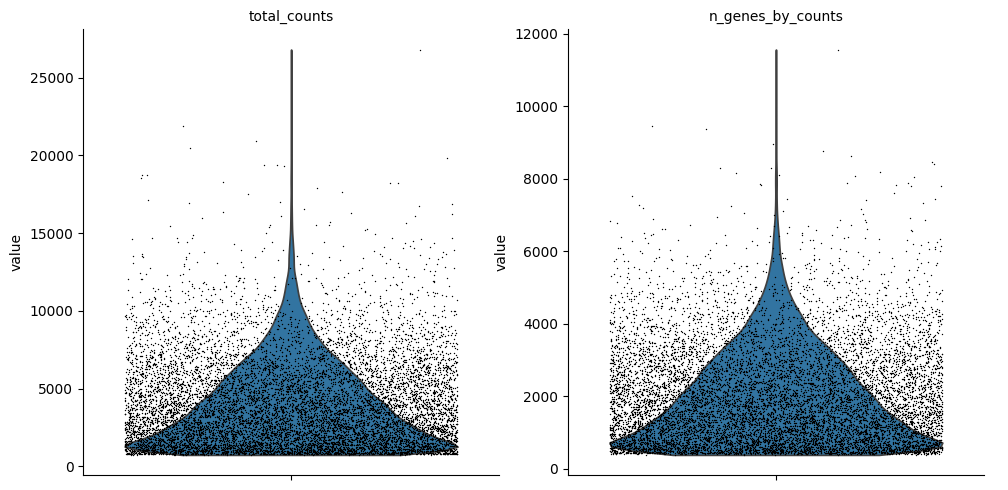

In [8]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [9]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 8000))
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 40000))


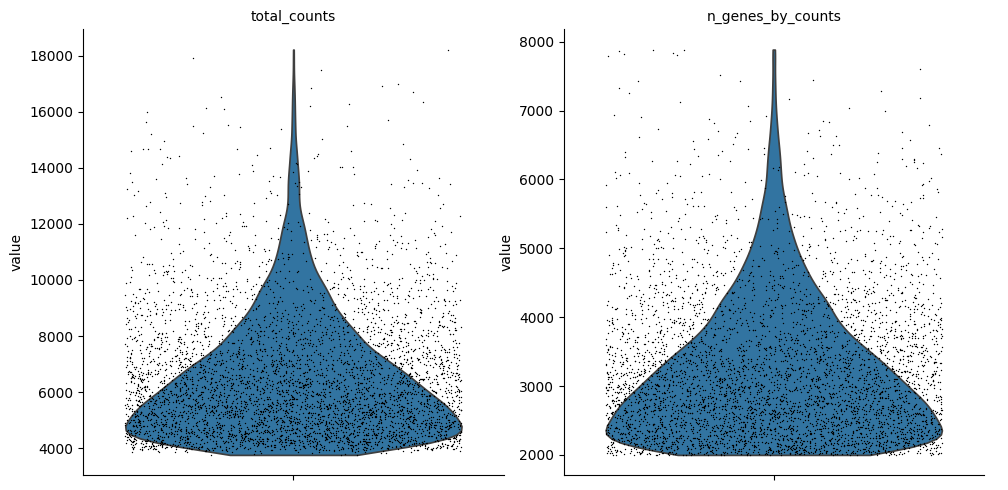

In [10]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [11]:
atac.layers['filtered'] = atac.X.copy()

In [12]:
atac.obs['NS']=1

Fetching Regions...: 100%|████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


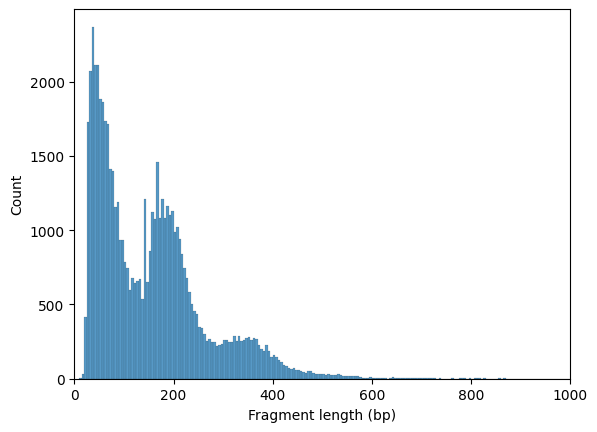

In [13]:
ac.pl.fragment_histogram(atac)

In [14]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:02<00:00, 356250.69it/s]


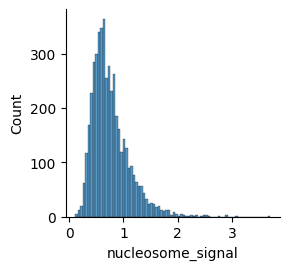

In [15]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

In [16]:
atac.layers["counts"] = atac.X

## Normalisation

In [17]:
atac.X = atac.layers["counts"]
ac.pp.tfidf(atac, scale_factor=1e4)

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / counts.sum(axis=0)).reshape(-1)


In [18]:
#sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
#sc.pp.log1p(atac)

## Feature selection

In [19]:
sc.pp.highly_variable_genes(atac, min_mean=0.5, max_mean=6, min_disp=.5)

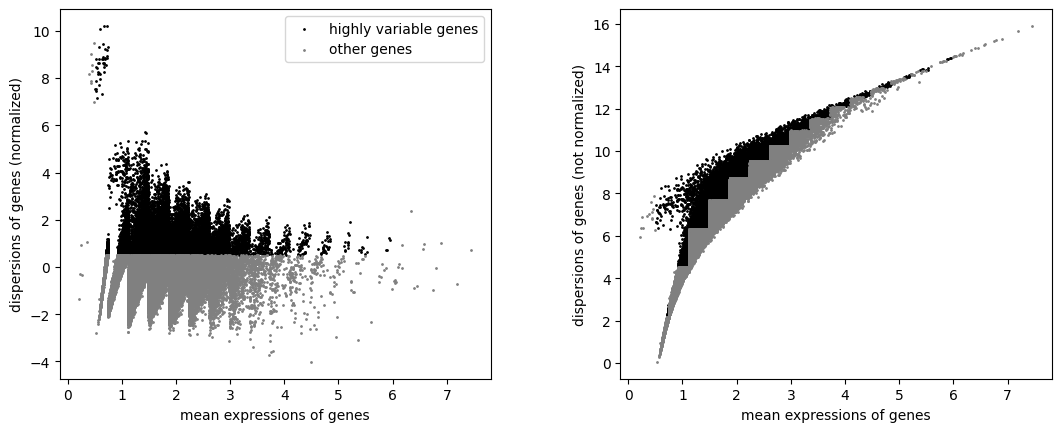

In [20]:
sc.pl.highly_variable_genes(atac)

In [21]:
np.sum(atac.var.highly_variable)

np.int64(32793)

In [22]:
atac.layers["tfidf"] = atac.X

In [23]:
ac.tl.lsi(atac)

In [24]:
# Removing first component per recommendation as it is usually associated with cell count and/or number of peaks
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [25]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [26]:
ac.tl.add_peak_annotation(atac, annotation=os.path.join(data_dir, "peak_annotation.tsv"))

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pa.loc[pa.distance.isnull(), "distance"] = ""


In [27]:
atac.uns['atac']['peak_annotation'].head()

,peak,distance,peak_type
gene,,,
DDX11L2,chr1:9791-10674,-1195,distal
ENSG00000241860,chr1:180863-181747,-7002,distal
ENSG00000241860,chr1:191063-191966,-17202,distal
ENSG00000235146,chr1:629513-630394,41885,distal
ENSG00000235146,chr1:633629-634442,46001,distal


In [28]:
atac

AnnData object with n_obs × n_vars = 4722 × 107928
    obs: 'size_factor', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'derivation', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'files', 'hvg', 'lsi', 'neighbors', 'atac'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'raw_counts', 'filtered', 'counts', 'tfidf'
    obsp: 'distances', 'connectivities'

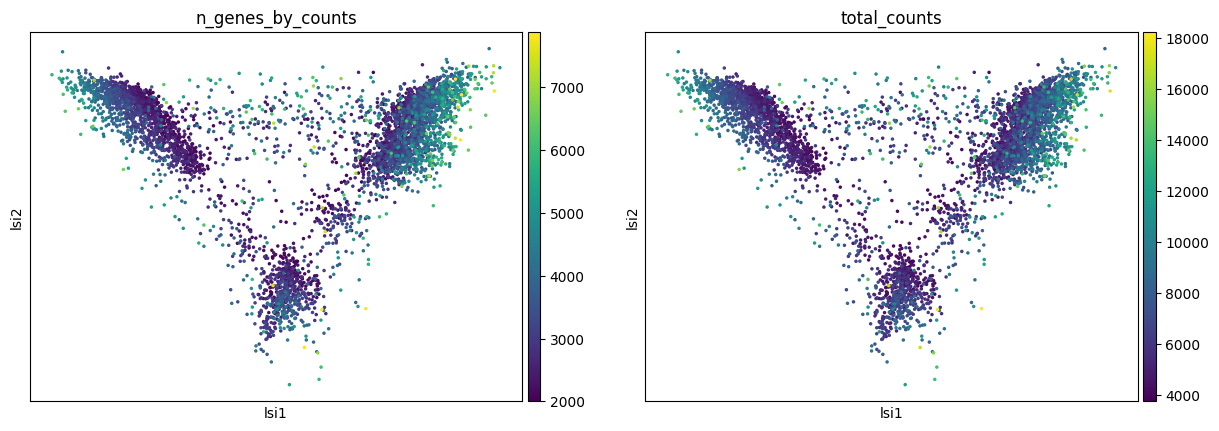

In [29]:
sc.pl.embedding(atac, basis = 'lsi', color=["n_genes_by_counts", "total_counts"])

In [30]:
#"VIM" in atac.uns['atac']['peak_annotation'].index
atac.X = atac.layers["tfidf"]

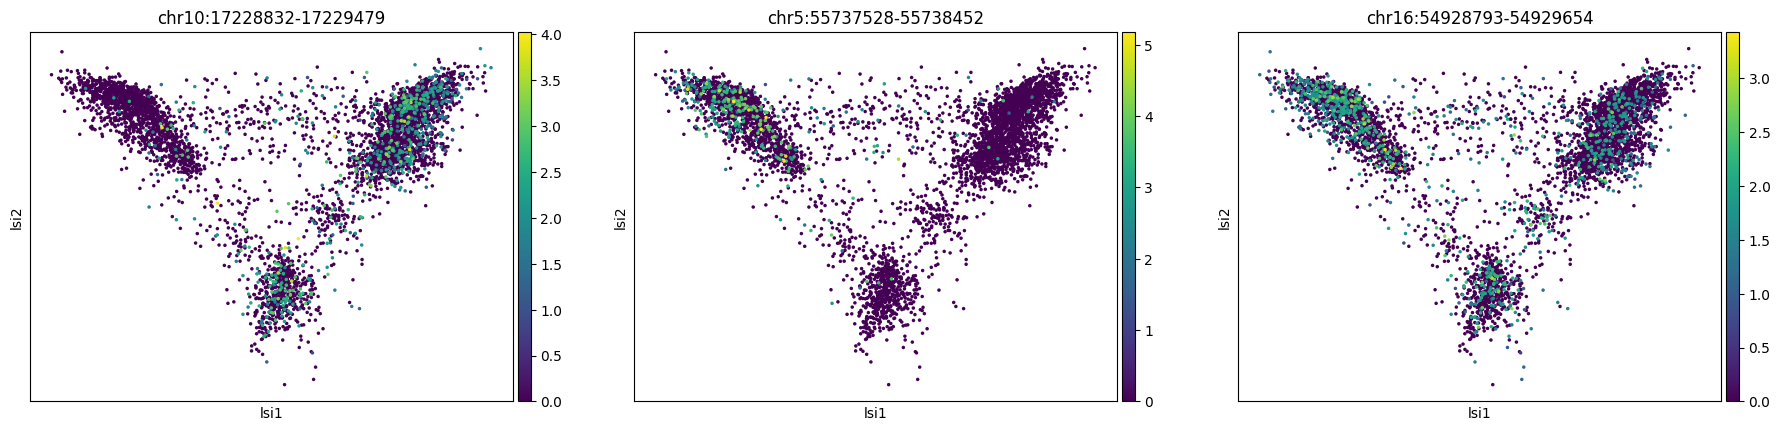

In [31]:
mu.atac.pl.lsi(atac, color = ['chr10:17228832-17229479', 'chr5:55737528-55738452', 'chr16:54928793-54929654'], average = 'total', use_raw = False)  # Cannot find the genes
# VIM: ENSG00000026025, chr10-17228832-17229479
# DDX4: ENSG00000152670, chr5:55737528-55738452
# CRNDE: ENSG00000245694, chr16:54848006-54848797, chr16:54928793-54929654

## Clustering

In [32]:
sc.tl.leiden(atac, resolution=.5)

/tmp/7574464/ipykernel_1009595/937485634.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.5)


In [33]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

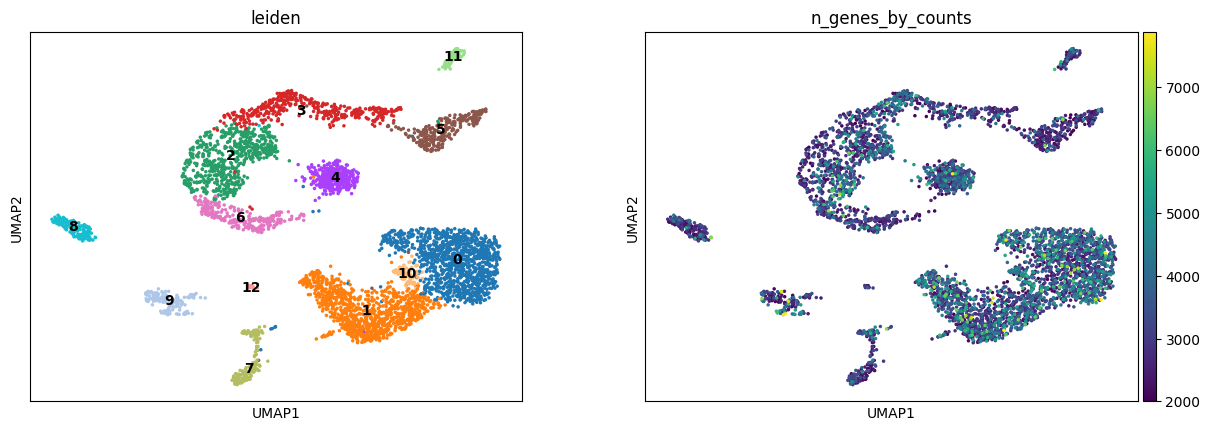

In [34]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

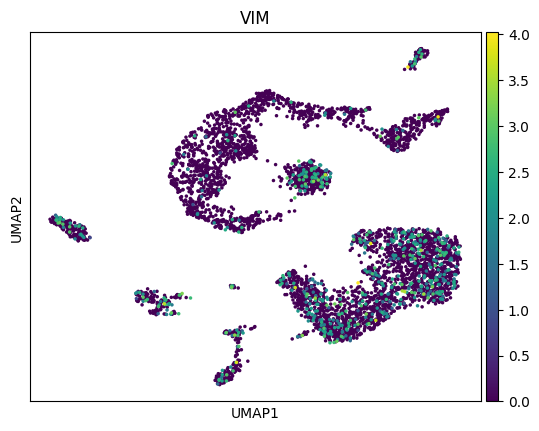

In [35]:
ac.pl.umap(atac, color = ["chr10:17228832-17229479"], average = "total", use_raw = False, title = "VIM")

In [36]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("display.max_columns", 10)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,...,11_g,11_p,12_n,12_g,12_p
0,chr2:224072401-224073333,SERPINE2,6.822722e-58,chr20:37911689-37912605,VSTM2L,...,"ENSG00000230552, LINC01117",2.527664e-08,chr6:24666498-24667388,"ACOT13, TDP2",0.000413
1,chr1:55380151-55381054,ENSG00000234810,3.741780e-44,chr1:39625195-39626101,"ENSG00000225903, HEYL",...,LINC01257,4.012604e-08,chr17:17591271-17592166,"PEMT, ENSG00000264666",0.000574
2,chr16:78505497-78506440,"ENSG00000260733, WWOX",3.148467e-44,chr7:73893236-73894145,TMEM270,...,ENSG00000237271,1.059234e-07,chr20:50730772-50731686,PARD6B,0.001486
3,chr2:238938342-238939372,LINC01940,1.081429e-43,chr8:98402408-98403308,KCNS2,...,PLA2G6,1.452144e-07,chr1:53325876-53326801,LRP8,0.001500
4,chr1:59178274-59179189,"LINC01358, FGGY-DT",2.624131e-43,chr20:23180156-23181052,ENSG00000230387,...,"EPHB1, ENSG00000286982, ENSG00000288700",1.679817e-07,chr12:51368661-51369549,GALNT6,0.001873
5,chr5:34496890-34497810,RAI14-DT,4.727781e-42,chr3:58165089-58166000,"FLNB, FLNB-AS1",...,TNS1,1.976305e-07,chr2:189783922-189784800,"ORMDL1, PMS1",0.002086
6,chr9:96232406-96233347,HSD17B3-AS1,3.696582e-40,chr16:85321659-85322544,ENSG00000287946,...,ENSG00000232328,3.722655e-07,chr19:49766237-49767144,AP2A1,0.002097
7,chr1:197367033-197367923,CRB1,7.573963e-40,chr7:55177468-55178404,"EGFR-AS1, EGFR",...,LOX,3.789131e-07,chr4:77075788-77076591,"ENSG00000289496, CCNI",0.002129
8,chr14:74974983-74975865,PGF,3.191464e-39,chr9:107251587-107252506,RAD23B,...,"IGFBP7-AS1, ENSG00000287369",7.773505e-07,chr11:67805290-67806103,FAM86C2P,0.002933
9,chr2:19037816-19038731,"ENSG00000287284, LINC01376",4.941286e-39,chr8:11600845-11601778,LINC00208,...,ENSG00000286806,8.173949e-07,chr19:42242474-42243315,GSK3A,0.003205


In [37]:
#atac.uns["rank_genes_groups"]["names"] = atac.uns["rank_genes_groups"]["genes"]

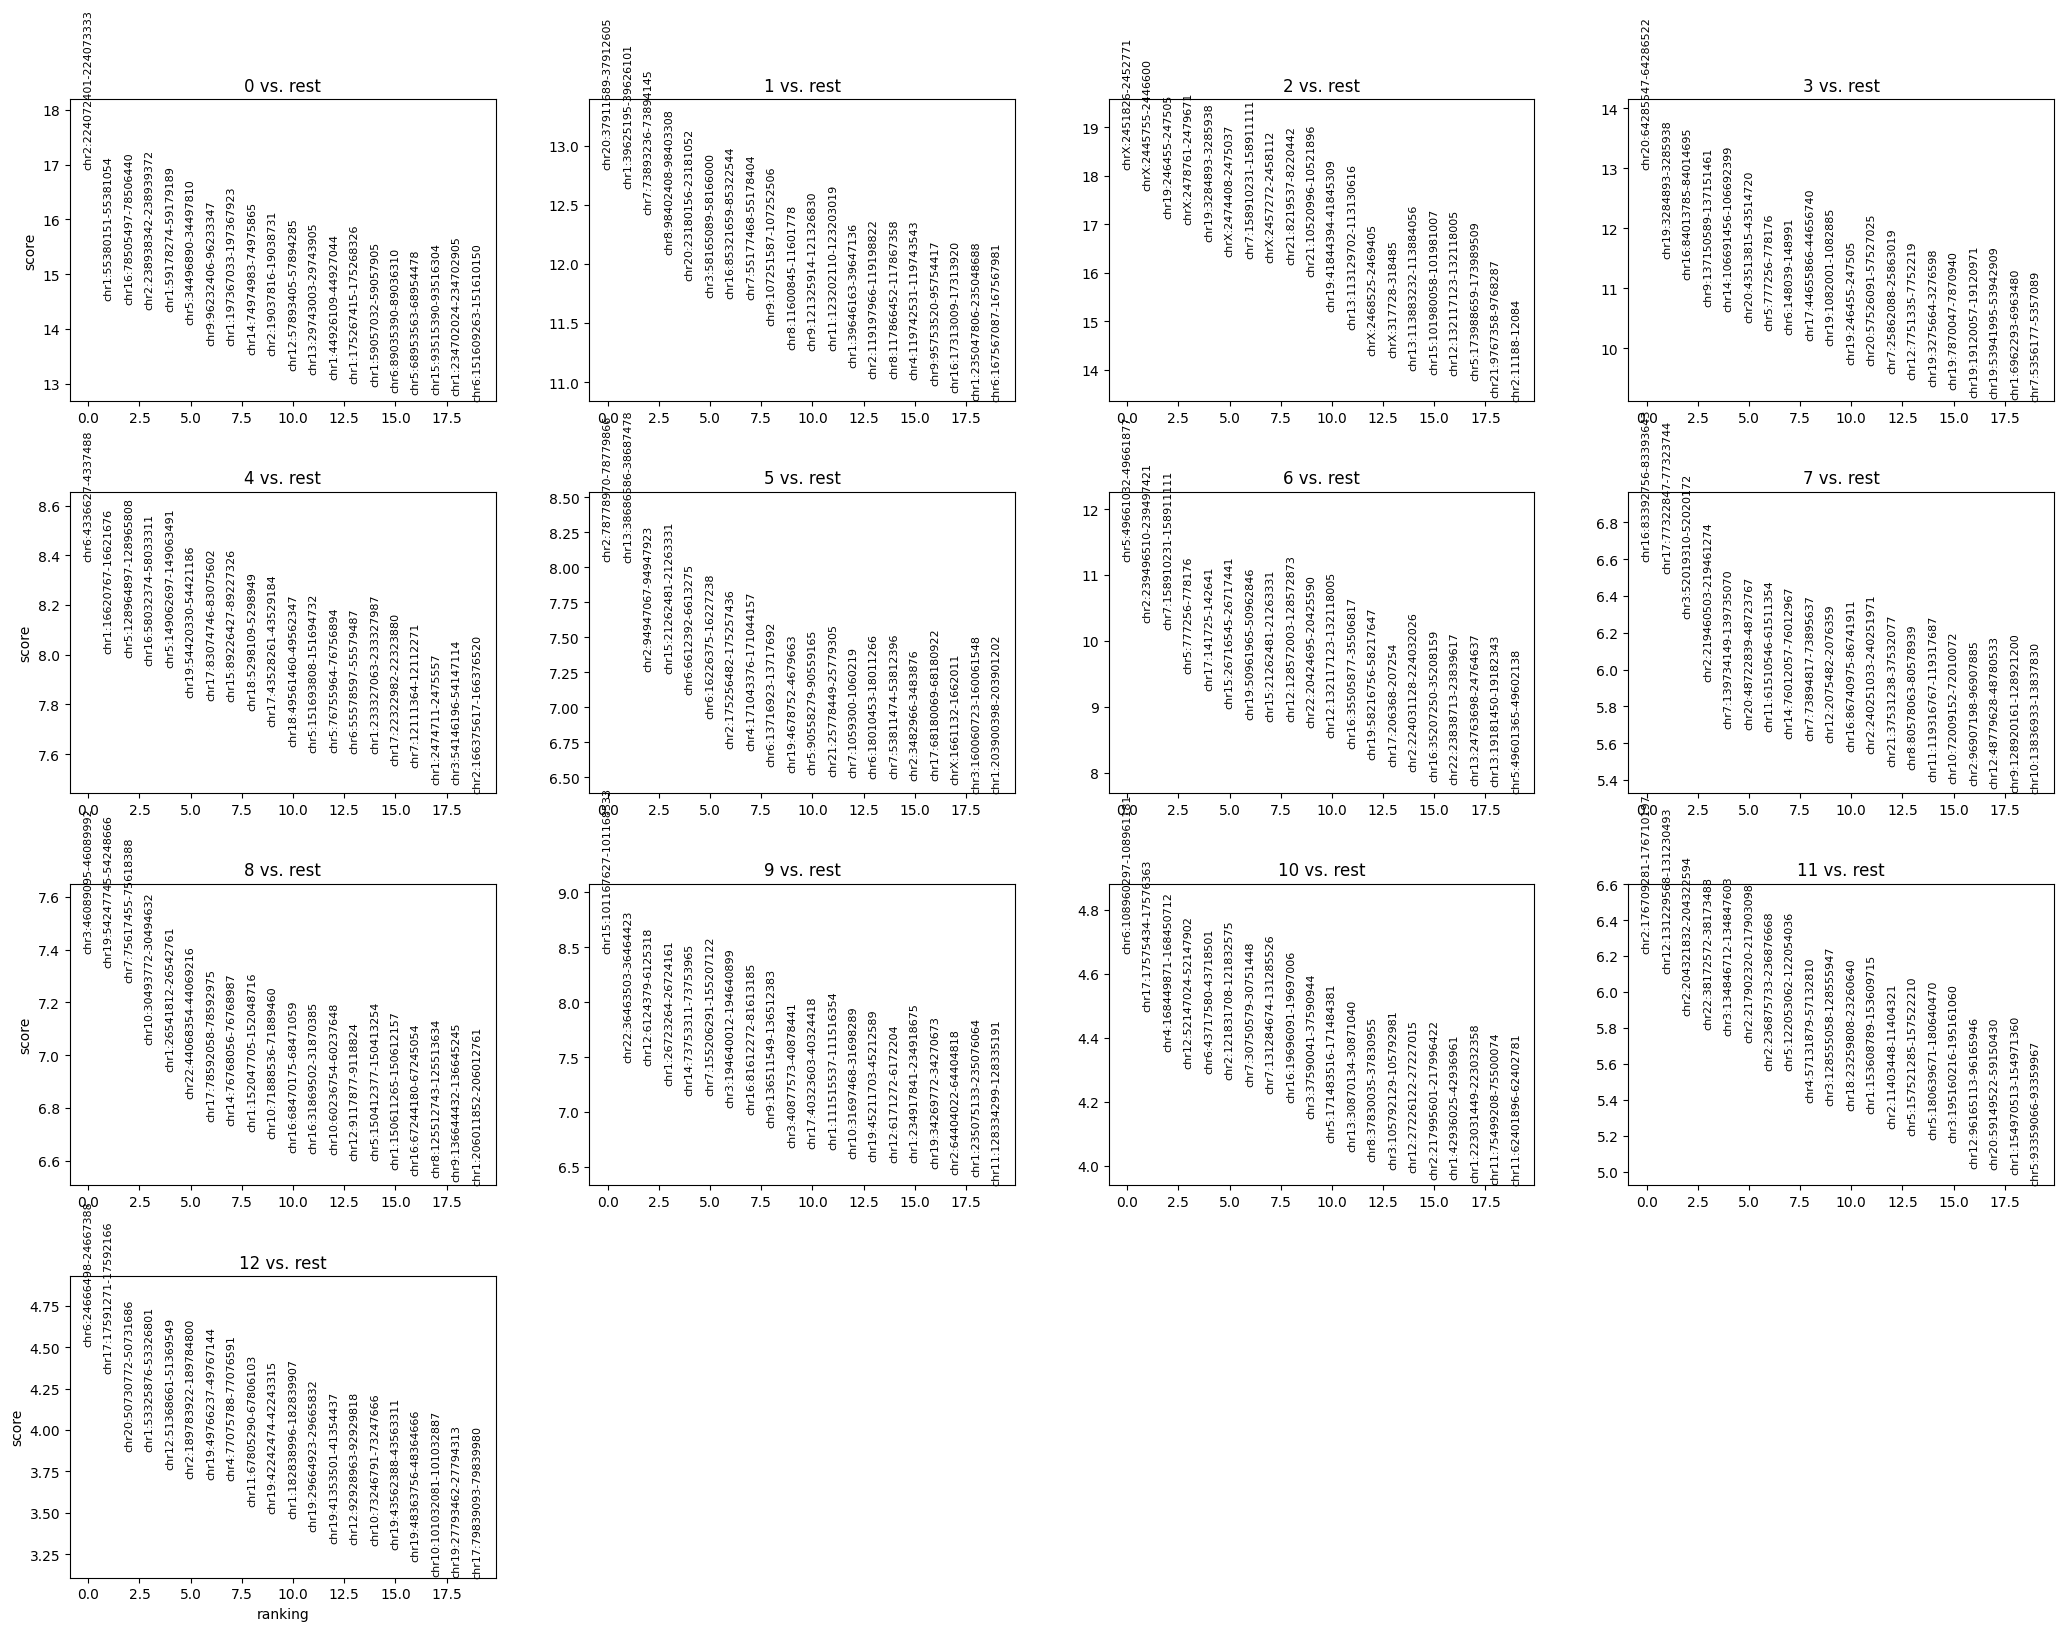

In [38]:
sc.pl.rank_genes_groups(atac, n_genes=20, sharey=False) #Empty spaces shows peaks not in genes

## Gene activity

In [44]:
atac.var.columns
peaks = atac.var.index.to_series().str.split("[:-]", expand = True)
peaks.columns = ["chrom", "start", "end"]
peaks["start"] = peaks["start"].astype("int")
peaks["end"] = peaks["end"].astype("int")
peaks

,chrom,start,end
chr1:9791-10674,chr1,9791,10674
chr1:180863-181747,chr1,180863,181747
chr1:191063-191966,chr1,191063,191966
chr1:629513-630394,chr1,629513,630394
chr1:633629-634442,chr1,633629,634442
...,...,...,...
KI270711.1:8999-9410,KI270711.1,8999,9410
KI270713.1:3900-4790,KI270713.1,3900,4790
KI270713.1:8040-8937,KI270713.1,8040,8937
KI270713.1:21347-22247,KI270713.1,21347,22247


In [47]:
activity_matrix = ac.tl.count_fragments_features(atac, features = peaks)

/tmp/7574464/ipykernel_1009595/28244377.py:1: FutureWarning: From v0.2, by default, unique fragments will be counted instead of reads. See muon#110 for details.
  ac.tl.count_fragments_features(atac, features = peaks)
100%|██████████████████████████████████| 107928/107928 [08:42<00:00, 206.74it/s]


AnnData object with n_obs × n_vars = 4722 × 107928
    obs: 'size_factor', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'leiden'
    var: 'chrom', 'start', 'end'

In [49]:
activity_matrix

AnnData object with n_obs × n_vars = 4722 × 107928
    obs: 'size_factor', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'leiden'
    var: 'chrom', 'start', 'end'

# PeakVI

In [60]:
scvi.settings.seed = 0
torch.set_float32_matmul_precision("high")
atac.X = atac.layers["raw_counts"]

[rank: 0] Seed set to 0


In [61]:
atac

AnnData object with n_obs × n_vars = 4722 × 107928
    obs: 'size_factor', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'leiden'
    var: 'gene_ids', 'feature_types', 'derivation', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'files', 'hvg', 'lsi', 'neighbors', 'atac', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_lsi', 'X_umap'
    varm: 'LSI'
    layers: 'raw_counts', 'filtered', 'counts', 'tfidf'
    obsp: 'distances', 'connectivities'

In [8]:
scvi.model.PEAKVI.setup_anndata(atac)

In [9]:
model = scvi.model.PEAKVI(atac)

In [10]:
model.train()

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 89/500:  18%|█▌       | 89/500 [06:22<29:25,  4.30s/it, v_num=1, train_loss=1.17e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 7825.775. Signaling Trainer to stop.


In [65]:
model_dir = "/faststorage/project/projectsInBioinformatics/workspaces/johan/PIB-johan-olesen/Notebooks/atac_models"

In [11]:
model.save(model_dir, overwrite=True)

In [66]:
model = scvi.model.PEAKVI.load(model_dir, adata = atac)

INFO     File                                                                                                      
         /faststorage/project/projectsInBioinformatics/workspaces/johan/PIB-johan-olesen/Notebooks/atac_models/mode
         l.pt already downloaded                                                                                   


/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scvi/model/base/_base_model.py:849: UserWarning: `var_names` for the loaded `model` does not match those used to train the model. For valid results, the former should match the latter.
  _validate_var_names(adata, var_names)


ValueError: Number of vars in `adata_target` not the same as source. Expected: 108177 Received: 107928

In [13]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
atac.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(11593, 18)

In [15]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(atac, use_rep=PEAKVI_LATENT_KEY)
# compute the umap
sc.tl.umap(atac, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(atac, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.5)

/tmp/7008258/ipykernel_3212273/2822361009.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)


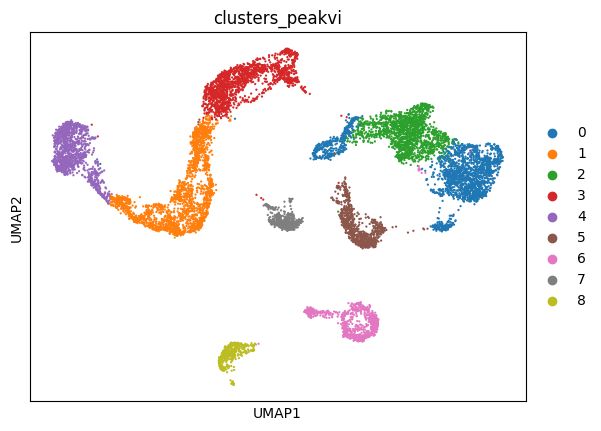

In [16]:
sc.pl.umap(atac, color = PEAKVI_CLUSTERS_KEY)

In [28]:
clusters = atac.obs[PEAKVI_CLUSTERS_KEY].unique()
clusters

['1', '4', '0', '3', '5', '2', '6', '7', '8']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

In [34]:
all_results = []

for cluster in clusters:
    # indices for current
    idx1 = np.where(atac.obs[PEAKVI_CLUSTERS_KEY] == cluster)[0]
    
    # DA vs. all other
    da_res = model.differential_accessibility(idx1=idx1, idx2=None)
    
    df = pd.DataFrame(da_res)
    df["cluster"] = cluster  # annotate current cluster
    all_results.append(df)

da_df = pd.concat(all_results, ignore_index=True)

DE...: 100%|████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.00s/it]


In [36]:
da_df.head()

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2,cluster
0,0.9902,True,4.615524,0.129521,0.024738,0.007601,0.137122,0.000954,0.025692,1
1,0.9896,True,4.555494,-0.716140,-0.228329,0.838980,0.122840,0.252863,0.024534,1
2,0.9894,True,4.536244,-0.033005,-0.009437,0.034421,0.001416,0.009542,0.000105,1
3,0.9870,True,4.329720,0.105267,0.021158,0.009359,0.114626,0.000954,0.022112,1
4,0.9866,True,4.299009,0.058201,0.011583,0.002070,0.060270,0.000000,0.011583,1
